# apo05 Workflow Demo
this is the demo data we've used a lot... it's originally from SLH, used to teach APO observing class for years

use it to package the PyDIS->specreduce->kosmos functions into new files, easily import, etc....

THEN the goal will be to use this as an outline for some basic reduction wrappers!

In [1]:
 # need notebook backend for interaction
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt

# file-handling stuff for user, options abound! I like Tables and Pandas DataFrames
import pandas as pd
from astropy.table import Table
from astropy import units as u

# import kosmos... if we do it right this should be the only other thing to import somday!
import kosmos
kosmos.__version__

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



'0.01'

In [2]:
DISPLAY = False

## 1. Bias

In [3]:
# to run on data, the user should provide lists of files to reduce.
# we can do this via the old IRAF way for now (b/c I'm old fashioned),
# but probably could design a more pythonic way (e.g. w/ glob or similar)

dir = 'kosmos/testdata/slh05_test/apo05/'
biasfiles_i = pd.read_table(dir + 'biaslist.txt', names=['impath'])
biasfiles = dir + biasfiles_i['impath'].values
biasfiles

array(['kosmos/testdata/slh05_test/apo05/05may31.0022r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0023r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0024r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0025r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0026r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0027r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0028r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0029r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0030r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0031r.fits'],
      dtype=object)

In [4]:
# use simple wrapper for median bias combining
bias = kosmos.biascombine(biasfiles) 
print(bias.shape)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(bias, origin='lower', aspect='auto', cmap=plt.cm.gray)
    plt.title('median bias frame')
    plt.clim(np.percentile(bias, (5, 98)))
    cb = plt.colorbar()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


(1078, 2098)


## 2. Flat

In [5]:
flatfiles_i = pd.read_table(dir + 'flatlist.txt', names=['impath'])
flatfiles = dir + flatfiles_i['impath'].values
flatfiles

array(['kosmos/testdata/slh05_test/apo05/05may31.0037r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0038r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0039r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0040r.fits',
       'kosmos/testdata/slh05_test/apo05/05may31.0041r.fits'],
      dtype=object)

In [6]:
# a wrapper around Combiner, the spectral response normalization, and the illumination correction
# this should work WITH or WITHOUT a bias given
flat, ilum = kosmos.flatcombine(flatfiles, bias=bias)

print(ilum.shape) # this is the indicies that are illuminated
print(flat.shape)
print(flat.unit)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(flat, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(.9,1.1)
    plt.title('median flat, bias & response corrected')
    cb = plt.colorbar()

/Users/james/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(748,)
(748, 2048)
adu / s


In [7]:
# if you turn off the illumination and response corrections, you just get a normalized median combined image
# i.e. could be used for photometry
medflat = kosmos.flatcombine(flatfiles, illumcor=False, responsecor=False)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(medflat, origin='lower', aspect='auto', cmap=plt.cm.inferno)
    plt.clim(np.percentile(medflat, (5, 98)))
    plt.title('median flat, NO corrections')
    cb = plt.colorbar()

print(medflat.shape)
print(medflat.unit)

(1028, 2048)
adu / s


In [8]:
# how to read in any science or calibration frame w/ a spectrum present

sci = dir + '05may31.0010r.fits'  # spectrum of the one target star, Gl 669A
sciimg = kosmos.proc(sci, bias=bias, ilum=ilum, flat=flat, trim=True)

print(sciimg.shape)
print(sciimg.unit)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(sciimg, origin='lower', aspect='auto')
    plt.clim(np.percentile(sciimg, (5, 98)))
    cb = plt.colorbar()
    plt.title(sci)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


(748, 2048)
adu / s


In [9]:
fcal = dir + '05may31.0020r.fits' # Flux std star observation, BD+282411

calimg = kosmos.proc(fcal, bias=bias, ilum=ilum, flat=flat, trim=True)
print(sciimg.shape)
print(sciimg.unit)

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(calimg, origin='lower', aspect='auto', cmap=plt.cm.Spectral_r)
    plt.clim(np.percentile(calimg, (5, 98)))
    cb = plt.colorbar()
    plt.title(fcal)

(748, 2048)
adu / s


## 4. Trace & Extract

In [10]:
cal_trace = kosmos.trace(calimg, display=DISPLAY, nbins=25)
sci_trace = kosmos.trace(sciimg, display=False, nbins=55)

sci_trace.shape

(2048,)

In [11]:
sci_ex, sci_sky = kosmos.BoxcarExtract(sciimg, sci_trace, display=DISPLAY, apwidth=10, skysep=5, skywidth=5)
cal_ex, cal_sky = kosmos.BoxcarExtract(calimg, cal_trace, display=False, apwidth=10, skysep=5, skywidth=5)

In [12]:
if DISPLAY:
    plt.errorbar(sci_ex.spectral_axis.value, sci_ex.flux.value - sci_sky.flux.value, 
                 yerr=sci_ex.uncertainty.array, linestyle='none')
    plt.xlabel(sci_ex.spectral_axis.unit)
    plt.ylabel(sci_ex.flux.unit)
    plt.title('Boxcar extract - sky')

## 5. Wavelength Calibration
This is (in my opinion) the hardest part of the entire pipeline.

In [13]:
arcfile = dir + '05may31.0035r.fits' # HeNeAr lamp
# read and process in the ARC LAMP, just like a normal spectrum
arcimg = kosmos.proc(arcfile, bias=bias, ilum=ilum, trim=True) 

if DISPLAY:
    plt.figure(figsize=(6,3))
    plt.imshow(arcimg, origin='lower', aspect='auto', cmap=plt.cm.afmhot)
    plt.plot(np.arange(len(sci_trace)), sci_trace) # for illustration, overplot the trace 
    plt.clim(np.percentile(arcimg, (5, 97)))
    cb = plt.colorbar()
    plt.title(arcfile)

In [14]:
# this data comes from the APO DIS red channel, which has wavelength axis backwards
# (despite not mentioning in the header)
wapprox = (np.arange(sciimg.shape[1]) - sciimg.shape[1]/2)[::-1] * sciimg.header['DISPDW'] + sciimg.header['DISPWC']
wapprox = wapprox * u.angstrom

if DISPLAY:
    plt.errorbar(wapprox.value, sci_ex.flux.value - sci_sky.flux.value, 
                 yerr=sci_ex.uncertainty.array, linestyle='none')
    plt.xlabel(wapprox.unit)
    plt.ylabel(sci_ex.flux.unit)
    plt.title('Boxcar extract - sky')

In [15]:
# extract the trace across the ARC image
sciarc_ex, _ = kosmos.BoxcarExtract(arcimg, sci_trace, apwidth=3, skysep=5, skywidth=5)
calarc_ex, _ = kosmos.BoxcarExtract(arcimg, cal_trace, apwidth=3, skysep=5, skywidth=5)

if DISPLAY:
    plt.plot(sciarc_ex.spectral_axis.value, sciarc_ex.flux.value)
    plt.xlabel(sciarc_ex.spectral_axis.unit)
    plt.ylabel(sciarc_ex.flux.unit)

# plt.ylim(-10,85)
# wow... so many little features here that can be used by DTW.

/Users/james/Dropbox/research_projects/kosmos/kosmos/apextract.py:297: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.nansum((onedspec[i]-skysubflux[i])) +


In [16]:
# a table of strong HeNeAr lines for the instrument in question, w/ units
apo_henear = Table.read(dir+'apohenear.ecsv', format='ascii.ecsv')['wave']
# print(apo_henear)

# use the "nearest" mode, which uses a list of known line features, and the
# approx wavelength from the header info. Starts in the middle, tries to find nearest
# peaks to those in the catalog... it works ok-ish for some modes

sci_xpts, sci_wpts = kosmos.identify_nearest(sciarc_ex, wapprox=wapprox, linewave=apo_henear, autotol=5)

19 lines matched from 20 within estimated range.


In [17]:
# plt.scatter(sci_xpts, sci_wpts)
# plt.plot(np.arange(len(wapprox)), wapprox)


In [18]:
# subtract the sky from the actual spectrum
cal_spectrum = cal_ex - cal_sky
sci_spectrum = sci_ex - sci_sky

In [19]:
cal_fit = kosmos.fit_wavelength(cal_spectrum, sci_xpts, sci_wpts, mode='interp', deg=3)
sci_fit = kosmos.fit_wavelength(sci_spectrum, sci_xpts, sci_wpts, mode='interp', deg=3)

if DISPLAY:
    plt.plot(sci_fit.spectral_axis, sci_fit.flux)

## 4. Airmass & Flux Calibration

In [20]:
# Get the airmass from the Headers... no fancy way to do this I guess? 
ZD = sciimg.header['ZD'] / 180.0 * np.pi
sci_airmass = 1.0/np.cos(ZD) # approximate Zenith Distance -> Airmass conversion

ZD = calimg.header['ZD'] / 180.0 * np.pi
cal_airmass = 1.0/np.cos(ZD)

print(sci_airmass, cal_airmass)

1.0668455410852924 1.052300816491183


In [21]:
# Select the observatory-specific airmass extinction profile from the provided "extinction" library
Xfile = kosmos.obs_extinction('apoextinct.dat')
# Xfile

In [29]:
# apply the airmass correction
# careful! overwriting the input spectrum here, bad form.
cal_fitX = kosmos.airmass_cor(cal_fit, cal_airmass, Xfile)
sci_fitX = kosmos.airmass_cor(sci_fit, sci_airmass, Xfile)

In [30]:
# Select the Standard Star reference spectrum from the provided "onedstd" library
standardstar = kosmos.onedstd('spec50cal/bd284211.dat')
# standardstar

In [31]:
# this is the sensitivity function, which converts the CCD data from
# ADU/S -> erg/s/cm2/A
sensfunc = kosmos.standard_sensfunc(cal_fitX, standardstar, mode='linear', display=False)

if DISPLAY:
    plt.plot(sensfunc.spectral_axis, sensfunc.flux)
    plt.xlabel('wavelength')
    plt.ylabel('sensfunc')
    
sensfunc.flux.unit

Unit("erg / (adu Angstrom cm2)")

In [32]:
# sci_fitX = kosmos.air_to_vac(sci_fitX)

In [33]:
final_spectrum = kosmos.apply_sensfunc(sci_fitX, sensfunc)

if DISPLAY:
    plt.plot(final_spectrum.wavelength, final_spectrum.flux, c='k')

    # having to convert the Spectrum1D parameters like this is annoying
    # and also inconsistent behavior with the uncertainty
    plt.errorbar(final_spectrum.wavelength.value, final_spectrum.flux.value, 
                 yerr=final_spectrum.uncertainty.array, alpha=0.2, c='C5')

    plt.xlabel('Wavelength ['+str(final_spectrum.wavelength.unit)+']')
    plt.ylabel('Flux ['+str(final_spectrum.flux.unit)+']')
    plt.title('Gl 669A – workflow example reduction')
    
final_spectrum.flux.unit

Unit("erg / (Angstrom cm2 s)")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


<IPython.core.display.Javascript object>


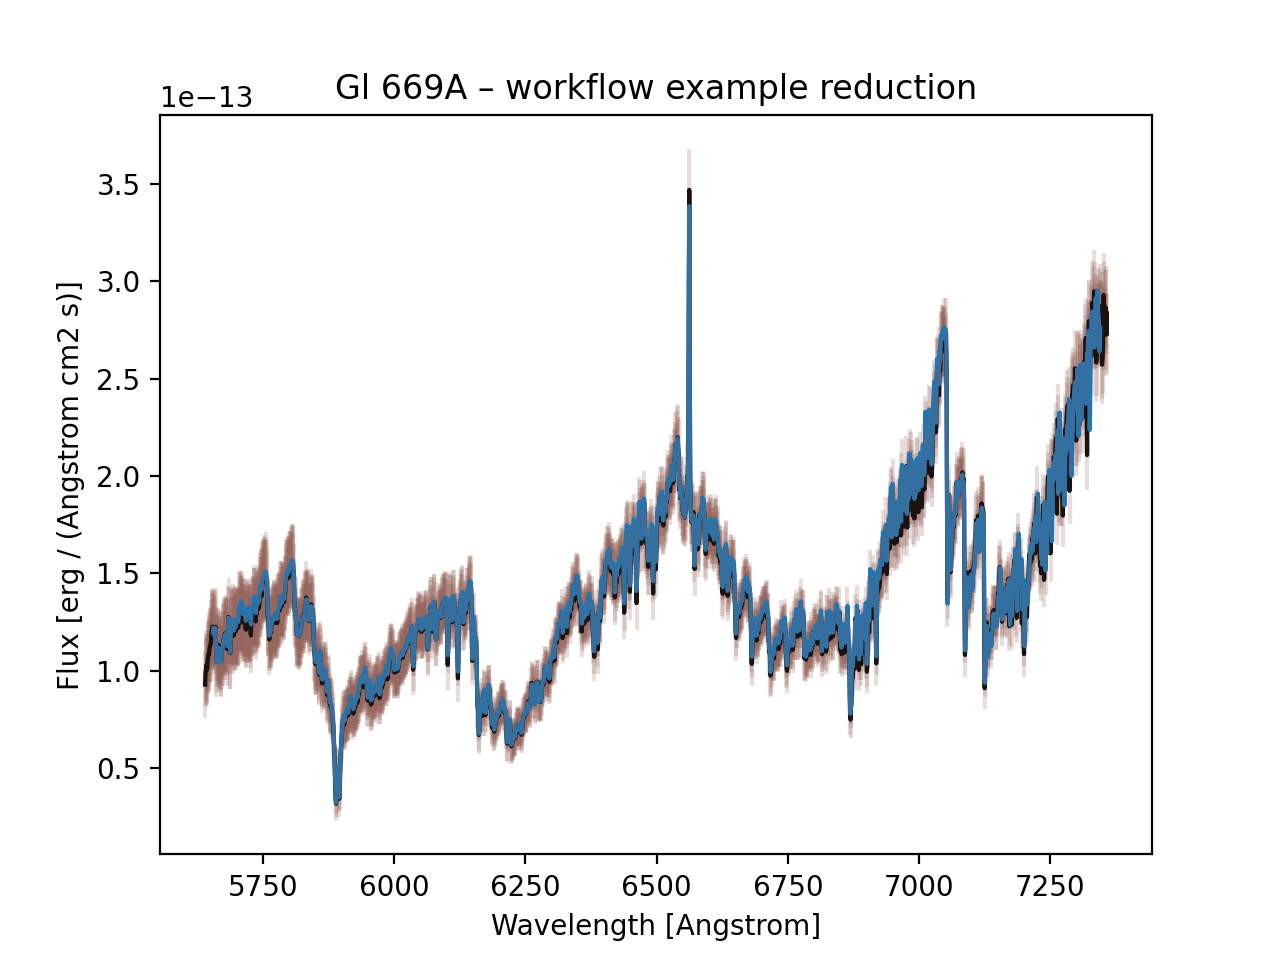

Text(0.5, 1.0, 'Gl 669A – workflow example reduction')

In [34]:
from astropy.nddata import CCDData
img = CCDData.read('kosmos/testdata/slh05_test/slh_reduction/gl669cal.fits', hdu=0)
# img.wcs

plt.plot(final_spectrum.wavelength, final_spectrum.flux, c='k')

# having to convert the Spectrum1D parameters like this is annoying
# and also inconsistent behavior with the uncertainty
plt.errorbar(final_spectrum.wavelength.value, final_spectrum.flux.value, 
             yerr=final_spectrum.uncertainty.array, alpha=0.2, c='C5')

plt.plot(5654.8668211415 + np.arange(2006)*0.84311144412739, img.data[0,0,:])

plt.xlabel('Wavelength ['+str(final_spectrum.wavelength.unit)+']')
plt.ylabel('Flux ['+str(final_spectrum.flux.unit)+']')
plt.title('Gl 669A – workflow example reduction')

In [161]:
from ccdproc import cosmicray_lacosmic

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


<IPython.core.display.Javascript object>


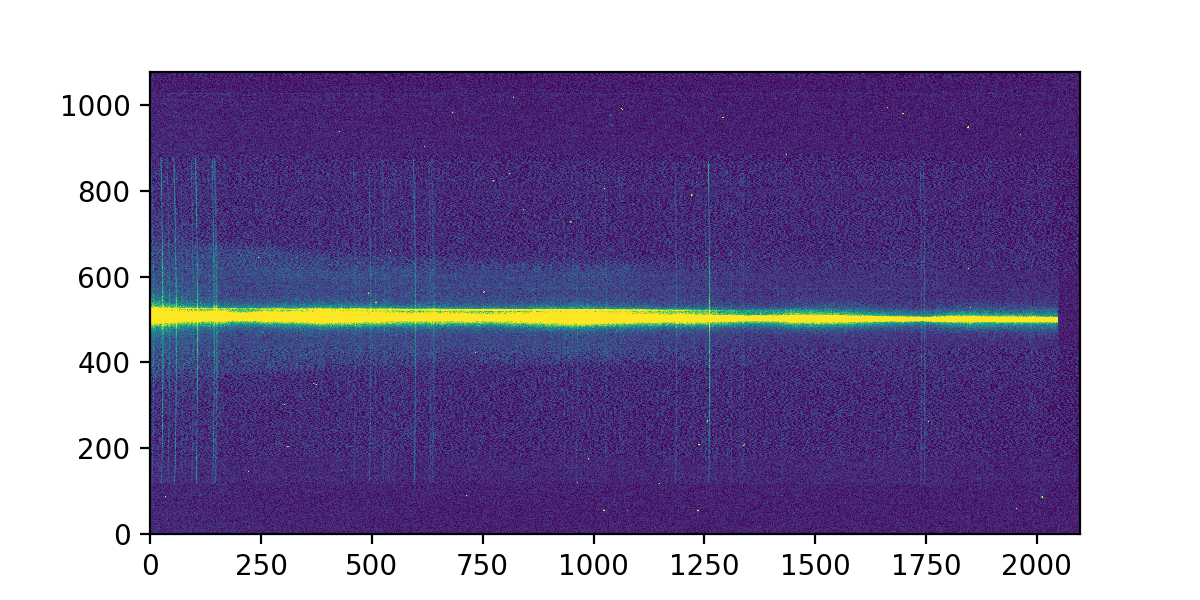

In [201]:
sci = '../../pydis_example/apo05/05may31.0010r.fits' # spectrum of the one target star, Gl 669A
sciimg_raw = CCDData.read(sci, unit=u.adu)

# Cosmic Rays should go HERE, before the basic reduction

plt.figure(figsize=(6,3))
plt.imshow(sciimg_raw, origin='lower', aspect='auto')
plt.clim(np.percentile(sciimg_raw, (5, 98)))

In [203]:
%%time
# If desired, this is how to easily do CR cleaning.
# It also will apply the gain, changing the img units from ADU/s to e-/s
# unless `gain_apply` is set to False
sciimg = cosmicray_lacosmic(sciimg_raw, gain=sciimg_raw.header['GAIN'] * u.electron / u.adu, 
                            readnoise=sciimg_raw.header['RDNOISE'] * u.electron, sigclip=6)


CPU times: user 2.67 s, sys: 150 ms, total: 2.82 s
Wall time: 2.86 s


In [204]:
# BASIC REDUCTION then procedes like normal...
# subtract BIAS, divide FLAT, ExpTime, put in units of ADU/s
sciimg.data = (sciimg.data - BIAS) / (sciimg_raw.header['EXPTIME'])
sciimg.unit = sciimg.unit / u.s

# trim off bias section
sciimg = trim_image(sciimg, fits_section=sciimg_raw.header['DATASEC'])

# Now remove FLAT from illuminated section
sciimg.data[ilum,:] = sciimg.data[ilum,:] / FLAT

INFO:astropy:overwriting Masked Objects's current mask with specified mask.


INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


In [ ]:
# besides cosmic rays, want to also add Telluric Correction, examples with TelFit
# https://telfit.readthedocs.io/en/latest/